In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import multiprocessing as mp
from datetime import datetime as dtm
from typing import Optional, Sequence
import itertools
import multiprocessing as mp

from darts.metrics import mape, mae

from darts.models.forecasting.varima import VARIMA
from darts.timeseries import TimeSeries as TS
from sklearn.model_selection import ParameterGrid as PG

In [2]:
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: SMAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return np.mean(numerator / denominator) * 100

def load_training_data(market_name):
    #df = pd.read_csv('/home/zqiao/data_flake/imputed data/{}_data.csv'.format(market_name), index_col=0)
    df = pd.read_csv('/home/zqiao/data_flake/imputed data/pho_t_data.csv',index_col=0)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

def train_auto_varima_mp(
    X_train,
    Y_train,
    X_test,
    Y_test,
    Y_primitive_test,
    min_d,
    max_d,
    trends,
    max_p,
    min_p,
    max_q,
    min_q,
    ntest,
    subset_li
):
    if trends is None:
        trends = [None]

    param_vals = {
        "p": [i for i in range(min_p, max_p + 1)],
        "d": [i for i in range(min_d, max_d + 1)],
        "q": [i for i in range(min_q, max_q + 1)],
        "trend": trends
        
    }
    param_grid = list(PG(param_vals))
    num_params = len(param_grid)

    results = {}
    pool = mp.Pool(processes=mp.cpu_count())
    for idx, params in enumerate(param_grid):
        print(f"training model {idx}/{num_params-1}: {params}")

        result = pool.apply_async(
            run_varima_experiment,
            kwds={
                "X_train": X_train,
                "Y_train": Y_train,
                "X_test": X_test,
                "Y_test": Y_test,
                "Y_primitive_test": Y_primitive_test,
                "params": params,
                "ntest": ntest
            },
        )
        params = str(params)
        results[params] = result


    pool.close()
    pool.join()

    for key, value in results.items():
        if value.get() is not None:
            results[key] = value.get()
    else:
            results[key] = 0
    res_df = pd.DataFrame.from_dict(results, orient='index', columns=['metric_val'])
    res_df = res_df.sort_values('metric_val', ascending=True)
    best_params = res_df.index.values[1]
    best_params = ast.literal_eval(best_params)
    p = best_params['p']
    d = best_params['d']
    q = best_params['q']
    trend = best_params['trend']


    return p,d,q,trend, res_df



def run_varima_experiment(X_train, X_test, Y_train, Y_test, Y_primitive_test, params, ntest):
    
    model = train_varima_model(X_train=X_train, Y_train=Y_train, **params)
    metric_val = evaluate_varima_model(model, X_test, Y_test, Y_primitive_test, ntest)

    return metric_val

def train_varima_model(X_train, Y_train, p, d, q, trend):
    
    if d not in [0, 1]:
        raise ValueError(f"d can only take on values 0 or 1")

    model = VARIMA(p=p, d=d, q=q, trend=trend)
    model.fit(Y_train, future_covariates=X_train)
    
    return model

def evaluate_varima_model(model, 
                          X_test, 
                          Y_test, 
                          Y_primitive_test,
                          ntest):

    pred = model.predict(ntest, future_covariates=X_test)

    pred_transfer = pred.pd_dataframe()
    Y_test_transfer = Y_test.pd_dataframe()
    Y_primitive_test_transfer = Y_primitive_test.pd_dataframe()
    pred_submkt_rent = pred_transfer['real_hedonic_rent_submarket']
    Y_primitive_test_submkt_rent = Y_primitive_test_transfer['real_hedonic_rent_submarket']
    Y_test_submkt_rent = Y_test_transfer['real_hedonic_rent_submarket']

    err = smape(Y_primitive_test_submkt_rent, pred_submkt_rent)


    return err


def run_varima_pipeline(market_name: str = None,
                        submkt_id: Optional[Sequence[str]] = None, 
                        target = "real_hedonic_rent_submarket",
                        features: list = None,
                        target_rolling: bool = None,
                        a_shift: bool = None,
                        ntest: int = None,
                        nlag: int = None,
                        rol_num: int = None,
                        min_d: int = None,
                        max_d: int = None,
                        trends: Optional[Sequence[str]] = None,
                        max_p: int = None,
                        min_p: int = None,
                        max_q: int = None,
                        min_q: int = None):
    
    if market_name is None:
        market_name = 'pho'
    
    if submkt_id is None:
        submkt_id = 'PHO037'

    df = load_training_data(market_name)

    grouped_df = df.groupby('research_submkt_id')
    for submkt, submkt_group in grouped_df:
        if submkt == submkt_id:
            submkt_df = submkt_group
    
    if ntest is None:
        ntest = 12
    
    if nlag is None:
        nlag = 6
        
    if features is None:
        features = [
            "gdp_histfc",
            "nominal_retail_sales_histfc",
            "employment_histfc",
            "real_ecommerce",
            "spread_3m10y",
            "real_retail_sales_ex_gas",
            "imports_us",
            "ecomm^2_pop",
            "weighted_pop_estimate_cryr",
            "weighted_hh_estimate_cryr"]
    
    target_cols = [target,'real_market_level_rent']
    pdf = submkt_df[target_cols + features].copy()
    
    if a_shift:
        #pdf["avrate"] = pdf["avrate"].shift(nlag)
        pdf["real_market_level_rent"] = pdf["real_market_level_rent"].shift(nlag)
        for col in features:
            pdf[col] = pdf[col].shift(nlag)
            
    Y_primitive = TS.from_dataframe(pdf[target_cols])
    Y_primitive_train, Y_primitive_test = Y_primitive[:-ntest], Y_primitive[-ntest:]

    if target_rolling:
        pdf[target] = pdf[target].rolling(rol_num).mean()
   
    pdf = pdf.dropna()
    X = TS.from_dataframe(pdf[features])
    Y = TS.from_dataframe(pdf[target_cols])
    X_train, X_test = X[:-ntest], X[-ntest:]
    Y_train, Y_test = Y[:-ntest], Y[-ntest:]
    
    p,d,q,trend,best_attributes, res_df = train_auto_varima_mp(
        X_train = X_train,
        Y_train = Y_train,
        X_test = X_test,
        Y_test = Y_test,
        Y_primitive_test = Y_primitive_test,
        min_d = min_d,
        max_d = max_d,
        trends = trends,
        max_p = max_p,
        min_p = min_p,
        max_q = max_q,
        min_q = min_q,
        ntest = ntest)

    print('This is the best params of varima model: p: ',p,', d: ',d,' q: ',q,' trend: ',trend)
    
    

    return X_train, Y_train, X_test, Y_test, Y_primitive_train, Y_primitive_test, p, d, q, trend, res_df




def get_feature_subsets(
        feature_space,
        subset_size=2,
        include_features: Optional[List[str]] = None,
        intersect_size: int = 1,
):
    subset_size = max(1, subset_size)
    subset_size = min(subset_size, len(feature_space))
    subset_li = []

    for subset in itertools.combinations(feature_space, subset_size):
        subset = list(subset)
        if include_features is not None:
            intersect_size = min(subset_size, intersect_size)
            _get_list_intersect_size(subset, include_features)

        subset_li.append(subset)

    return subset_li

In [4]:
X_train, Y_train, X_test, Y_test, Y_primitive_train, Y_primitive_test, p, d, q, trend, res_df = run_varima_pipeline(market_name = 'pho',
                                                        submkt_id = 'PHO037', 
                                                        target = 'real_hedonic_rent_submarket',
                                                        features = None,
                                                        target_rolling = True,
                                                        a_shift = True,
                                                        ntest = 24,
                                                        nlag = 3,
                                                        rol_num = 6,                      
                                                        min_d = 0,
                                                        max_d = 1,
                                                        trends = [None,'ct','t'],
                                                        max_p = 3,
                                                        min_q = 1,
                                                        max_q = 3,
                                                        min_p = 1)

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: 

training model 0/53: {'d': 0, 'p': 1, 'q': 1, 'trend': None}
training model 1/53: {'d': 0, 'p': 1, 'q': 1, 'trend': 'ct'}
training model 2/53: {'d': 0, 'p': 1, 'q': 1, 'trend': 't'}
training model 3/53: {'d': 0, 'p': 1, 'q': 2, 'trend': None}
training model 4/53: {'d': 0, 'p': 1, 'q': 2, 'trend': 'ct'}
training model 5/53: {'d': 0, 'p': 1, 'q': 2, 'trend': 't'}
training model 6/53: {'d': 0, 'p': 1, 'q': 3, 'trend': None}
training model 7/53: {'d': 0, 'p': 1, 'q': 3, 'trend': 'ct'}
training model 8/53: {'d': 0, 'p': 1, 'q': 3, 'trend': 't'}
training model 9/53: {'d': 0, 'p': 2, 'q': 1, 'trend': None}
training model 10/53: {'d': 0, 'p': 2, 'q': 1, 'trend': 'ct'}
training model 11/53: {'d': 0, 'p': 2, 'q': 1, 'trend': 't'}
training model 12/53: {'d': 0, 'p': 2, 'q': 2, 'trend': None}
training model 13/53: {'d': 0, 'p': 2, 'q': 2, 'trend': 'ct'}
training model 14/53: {'d': 0, 'p': 2, 'q': 2, 'trend': 't'}
training model 15/53: {'d': 0, 'p': 2, 'q': 3, 'trend': None}
training model 16/53: {

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generica

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: 

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification is

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: 

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generica

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

This is the best params of varima model: p:  1 , d:  0  q:  1  trend:  ct


In [5]:
res_df

,metric_val
"{'d': 1, 'p': 3, 'q': 3, 'trend': 't'}",0.000000
"{'d': 0, 'p': 1, 'q': 1, 'trend': 'ct'}",2.612252
"{'d': 0, 'p': 1, 'q': 3, 'trend': 'ct'}",2.636600
"{'d': 0, 'p': 1, 'q': 2, 'trend': 'ct'}",2.655914
"{'d': 0, 'p': 1, 'q': 1, 'trend': None}",2.865734
"{'d': 0, 'p': 1, 'q': 3, 'trend': None}",2.871052
"{'d': 0, 'p': 1, 'q': 2, 'trend': None}",2.883603
"{'d': 0, 'p': 1, 'q': 1, 'trend': 't'}",3.903980
"{'d': 0, 'p': 1, 'q': 3, 'trend': 't'}",3.983363
"{'d': 0, 'p': 1, 'q': 2, 'trend': 't'}",4.027597


In [6]:
final_model = train_varima_model(X_train, Y_train, p, d, q, trend)
Y_pred = final_model.predict(24, future_covariates=X_test)

/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/zqiao/.pyenv/versions/3.9.12/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generica

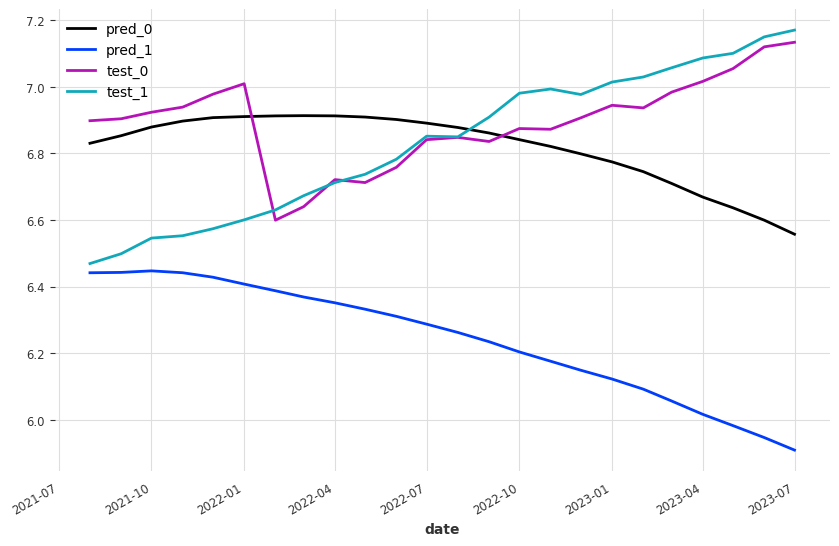

In [8]:
plt.figure(figsize=(10, 6)) 

Y_pred.plot(label='pred')
Y_primitive_test.plot(label='test')

In [ ]:
X_train, Y_train, X_test, Y_test,p, d, q, trend, res_df = run_varima_pipeline(market_name = 'pho',
                                                       submkt_id = 'PHO038', 
                                                       target = 'real_hedonic_rent_submarket',
                                                       features = None,
                                                       target_rolling = True,
                                                       a_shift = True,
                                                       ntest = 24,
                                                       nlag = 12,
                                                       rol_num = 12,                      
                                                       min_d = 0,
                                                       max_d = 1,
                                                       trends = [None,'ct','t'],
                                                       max_p = 3,
                                                       min_q = 1,
                                                       max_q = 3,
                                                       min_p = 1)

In [ ]:
res_df

In [ ]:
final_model = train_varima_model(X_train, Y_train, p, d, q, trend)
Y_pred = final_model.predict(24, future_covariates=X_test)

In [ ]:
Y_pred.plot()
Y_test.plot()
Y_train.plot()

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools
import ast
from typing import Optional, Sequence, List
from pmdarima.arima import auto_arima as AA
from sklearn.model_selection import ParameterGrid as PG
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    SlidingWindowSplitter,
)
from sktime.performance_metrics.forecasting import smape
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import ARIMA, StepwiseWrapper
from sktime.utils.validation.forecasting import check_y


def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: SMAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    return np.mean(numerator / denominator) * 100


def load_training_data(market_name):
    # df = pd.read_csv('/home/zqiao/data_flake/imputed data/{}_data.csv'.format(market_name), index_col=0)
    df = pd.read_csv(f'/mnt/container1/zqiao_Workspace/link-research/ad-hoc/zq-sandbox/submkt_data/submkt_train_data/{market_name}_submkt_train_test_data.csv', index_col=0)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df


def train_auto_varima_mp(
        X_train,
        Y_train,
        X_test,
        Y_test,
        Y_primitive_test,
        min_d,
        max_d,
        trends,
        max_p,
        min_p,
        max_q,
        min_q,
        ntest,
        subset_li
):
    if trends is None:
        trends = [None]

    param_vals = {
        "p": [i for i in range(min_p, max_p + 1)],
        "d": [i for i in range(min_d, max_d + 1)],
        "q": [i for i in range(min_q, max_q + 1)],
        "trend": trends,
        "subset_li": subset_li

    }
    param_grid = list(PG(param_vals))
    num_params = len(param_grid)

    results = {}
    pool = mp.Pool(processes=mp.cpu_count())
    for idx, params in enumerate(param_grid):
        print(f"training model {idx}/{num_params - 1}: {params}")

        result = pool.apply_async(
            run_varima_experiment,
            kwds={
                "X_train": X_train,
                "X_test": X_test,
                "Y_train": Y_train,
                "Y_test": Y_test,
                "Y_primitive_test": Y_primitive_test,
                "params": params,
                "ntest": ntest
            },
        )
        params = str(params)
        results[params] = result

    pool.close()
    pool.join()

    for key, value in results.items():
        if value.get() is not None:
            results[key] = value.get()
        else:
            results[key] = 0
    res_df = pd.DataFrame.from_dict(results, orient='index', columns=['metric_val'])
    res_df = res_df.sort_values('metric_val', ascending=True)
    best_params = res_df.index.values[1]
    best_params = ast.literal_eval(best_params)
    p = best_params['p']
    d = best_params['d']
    q = best_params['q']
    trend = best_params['trend']
    attribues = best_params['subset_li']

    return p, d, q, trend, attribues, res_df


def run_varima_experiment(X_train, X_test, Y_train, Y_test, Y_primitive_test, params, ntest):
    X_train = X_train[params['subset_li']]
    X_test = X_test[params['subset_li']]
    model = train_varima_model(X_train=X_train, Y_train=Y_train, **params)
    metric_val = evaluate_varima_model(model, X_test, Y_test, Y_primitive_test, ntest)

    return metric_val


def train_varima_model(X_train, Y_train, p, d, q, trend):
    if d not in [0, 1]:
        raise ValueError(f"d can only take on values 0 or 1")

    model = VARIMA(p=p, d=d, q=q, trend=trend)
    model.fit(Y_train, future_covariates=X_train)

    return model


def evaluate_varima_model(model, X_test, Y_test, Y_primitive_test, ntest):
    pred = model.predict(ntest, future_covariates=X_test)

    pred_transfer = pred.pd_dataframe()
    Y_test_transfer = Y_test.pd_dataframe()
    Y_primitive_test_transfer = Y_primitive_test.pd_dataframe()
    pred_submkt_rent = pred_transfer['real_hedonic_rent_submarket']
    Y_primitive_test_submkt_rent = Y_primitive_test_transfer['real_hedonic_rent_submarket']
    Y_test_submkt_rent = Y_test_transfer['real_hedonic_rent_submarket']

    err = smape(Y_primitive_test_submkt_rent, pred_submkt_rent)

    return err


def run_varima_pipeline(market_name: str = None,
                        submkt_id: Optional[Sequence[str]] = None,
                        target="real_hedonic_rent_submarket",
                        features: list = None,
                        target_rolling: bool = None,
                        a_shift: bool = None,
                        ntest: int = None,
                        nlag: int = None,
                        rol_num: int = None,
                        min_d: int = None,
                        max_d: int = None,
                        trends: Optional[Sequence[str]] = None,
                        max_p: int = None,
                        min_p: int = None,
                        max_q: int = None,
                        min_q: int = None):
    if market_name is None:
        market_name = 'pho'

    if submkt_id is None:
        submkt_id = 'PHO037'

    df = load_training_data(market_name)

    grouped_df = df.groupby('research_submkt_id')
    for submkt, submkt_group in grouped_df:
        if submkt == submkt_id:
            submkt_df = submkt_group

    if ntest is None:
        ntest = 12

    if nlag is None:
        nlag = 6

    if features is None:
        features = [
            "gdp_histfc",
            "nominal_retail_sales_histfc",
            "employment_histfc",
            "real_ecommerce",
            "spread_3m10y",
            "real_retail_sales_ex_gas",
            "imports_us",
            "ecomm^2_pop",
            "weighted_pop_estimate_cryr",
            "weighted_hh_estimate_cryr"]

    target_cols = [target, 'real_market_level_rent']
    pdf = submkt_df[target_cols + features].copy()

    if a_shift:
        # pdf["avrate"] = pdf["avrate"].shift(nlag)
        pdf["real_market_level_rent"] = pdf["real_market_level_rent"].shift(nlag)
        for col in features:
            pdf[col] = pdf[col].shift(nlag)

    Y_primitive = TS.from_dataframe(pdf[target_cols])
    Y_primitive_train, Y_primitive_test = Y_primitive[:-ntest], Y_primitive[-ntest:]

    if target_rolling:
        pdf[target] = pdf[target].rolling(rol_num).mean()

    pdf = pdf.dropna()
    X = TS.from_dataframe(pdf[features])
    Y = TS.from_dataframe(pdf[target_cols])
    X_train, X_test = X[:-ntest], X[-ntest:]
    Y_train, Y_test = Y[:-ntest], Y[-ntest:]

    feature_space = features

    subset_li = get_feature_subsets(feature_space)

    p, d, q, trend, attributes, res_df = train_auto_varima_mp(
        X_train=X_train,
        Y_train=Y_train,
        X_test=X_test,
        Y_test=Y_test,
        Y_primitive_test=Y_primitive_test,
        min_d=min_d,
        max_d=max_d,
        trends=trends,
        max_p=max_p,
        min_p=min_p,
        max_q=max_q,
        min_q=min_q,
        ntest=ntest,
        subset_li=subset_li
    )

    print('This is the best params of varima model: p:', p, ', d:', d, 'q:', q, ', trend:', trend, ', attributes:', attributes)

    return X_train, Y_train, X_test, Y_test, Y_primitive_train, Y_primitive_test, p, d, q, trend, attributesributes, res_df


def _get_list_intersect_size(list1, list2):
    return len(set(list1) & set(list2))


def get_feature_subsets(
        feature_space,
        subset_size,
        include_features=None,
        intersect_size=1,
        num_processes=None,
):
    subset_size = max(1, subset_size)
    subset_size = min(subset_size, len(feature_space))
    subset_li = []

    if num_processes is None:
        num_processes = mp.cpu_count()

    with mp.Pool(processes=num_processes) as pool:
        results = []
        for subset in itertools.combinations(feature_space, subset_size):
            subset = list(subset)
            if include_features is not None:
                intersect_size = min(subset_size, intersect_size)
                _get_list_intersect_size(subset, include_features)

            results.append(subset)

        subset_li = pool.map(_process_subset, results)

    return subset_li


def _process_subset(subset):
    return subset



In [ ]:
run_varima_pipeline(market_name="pho", submkt_id="PHO037", target="real_hedonic_rent_submarket", features=["gdp_histfc", "nominal_retail_sales_histfc"], target_rolling=True, a_shift=True, ntest=12, nlag=6, rol_num=10, min_d=0, max_d=1, trends=["c", "ct", "ctt"], max_p=3, min_p=0, max_q=3, min_q=0)
